Using MDAnalysis version 2.8.0


quin fitxer de molecules vols analitzar?  8zkw.pdb


92
Hi ha 92 ALA
34
7 té algun problema a la ARG
14 té algun problema a la ARG
15 té algun problema a la ARG
Hi ha 31 ARG
38
Hi ha 38 ASN
19
Hi ha 19 ASP
30
20 té algun problema a la CYS
Hi ha 29 CYS
30
Hi ha 30 GLN
37
11 té algun problema a la GLU
26 té algun problema a la GLU
Hi ha 35 GLU
72
Hi ha 72 GLY
16
Hi ha 16 HIS
92
Hi ha 92 ILE
128
Hi ha 128 LEU
42
8 té algun problema a la LYS
9 té algun problema a la LYS
29 té algun problema a la LYS
Hi ha 39 LYS
58
Hi ha 58 MET
68
Hi ha 68 PHE
66
Hi ha 66 PRO
52
12 té algun problema a la SER
38 té algun problema a la SER
Hi ha 50 SER
60
Hi ha 60 THR
20
Hi ha 20 TRP
38
Hi ha 38 TYR
88
Hi ha 88 VAL


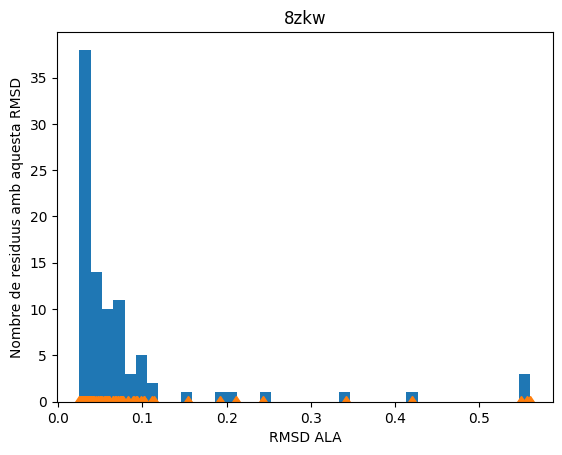

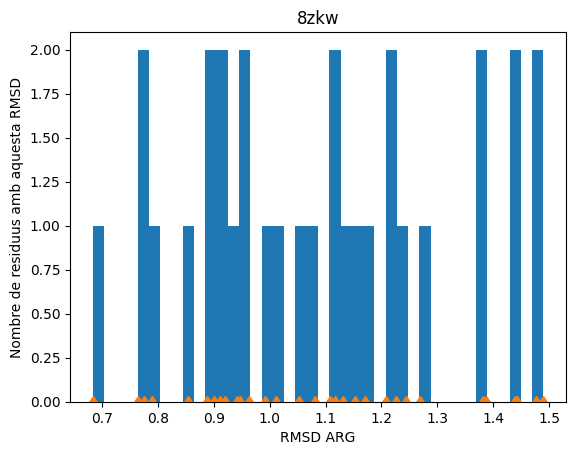

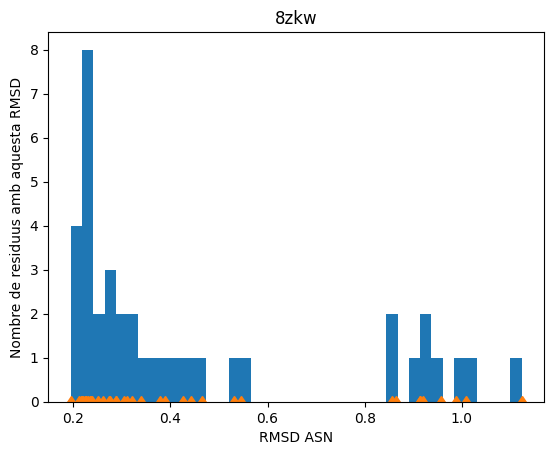

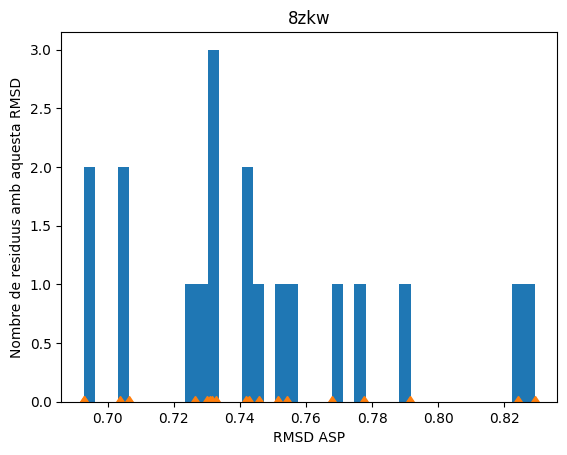

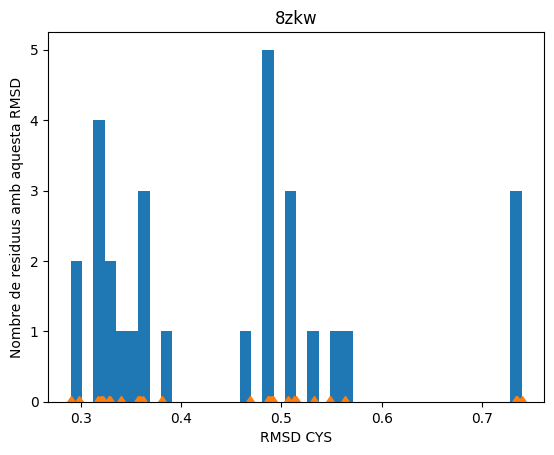

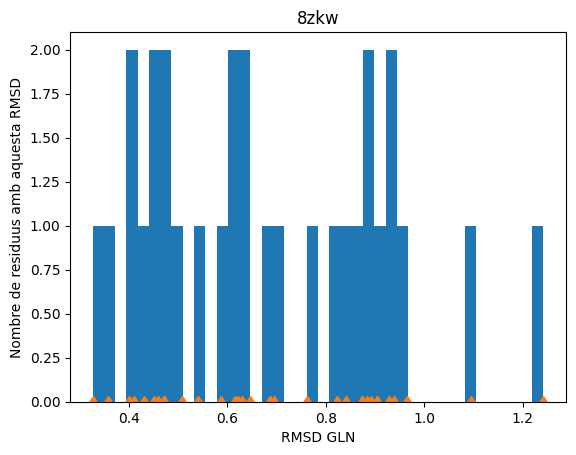

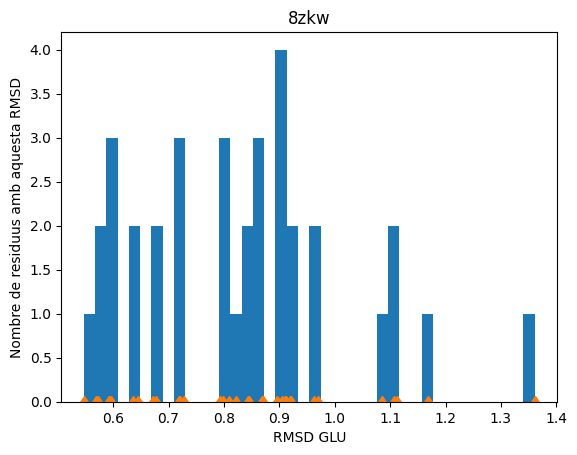

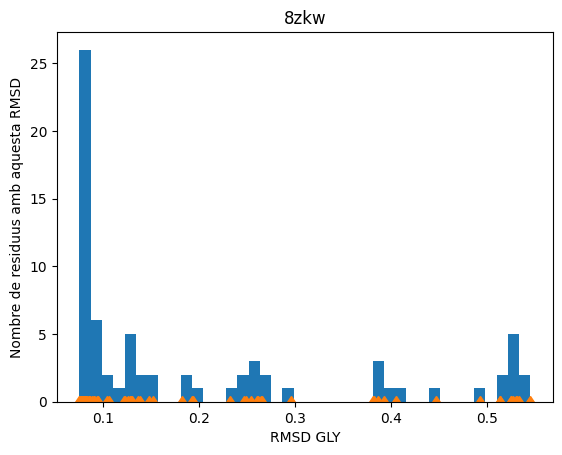

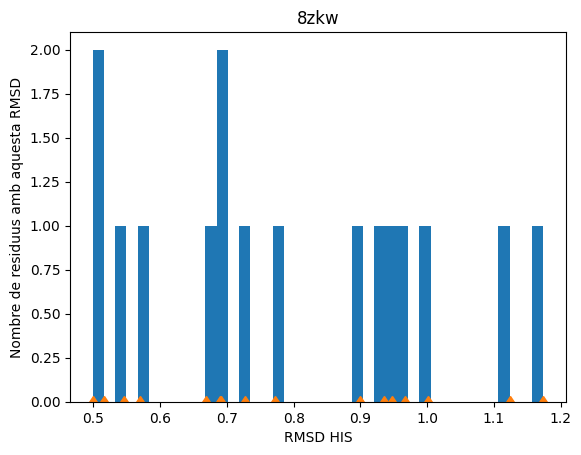

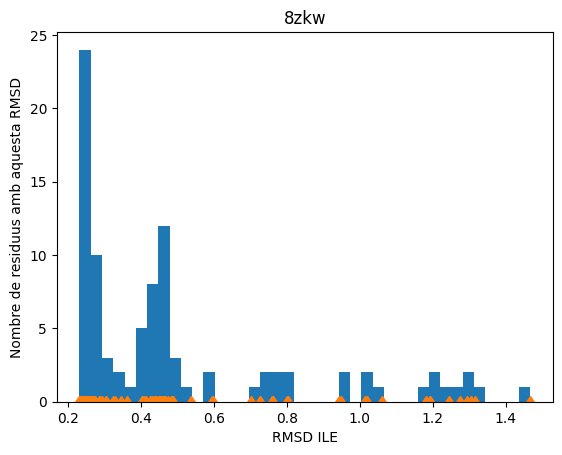

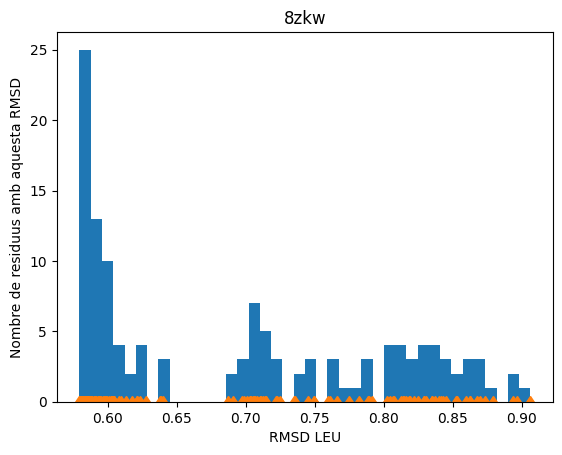

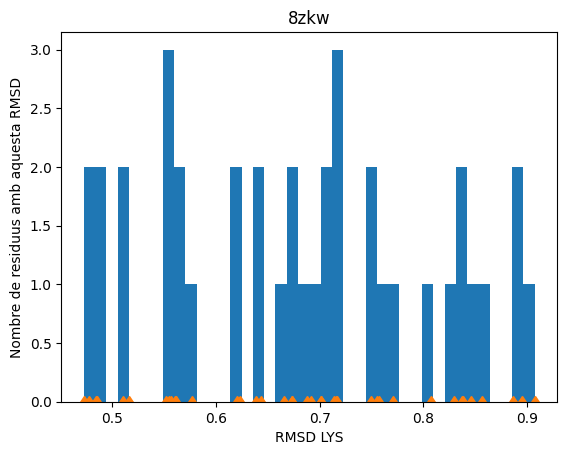

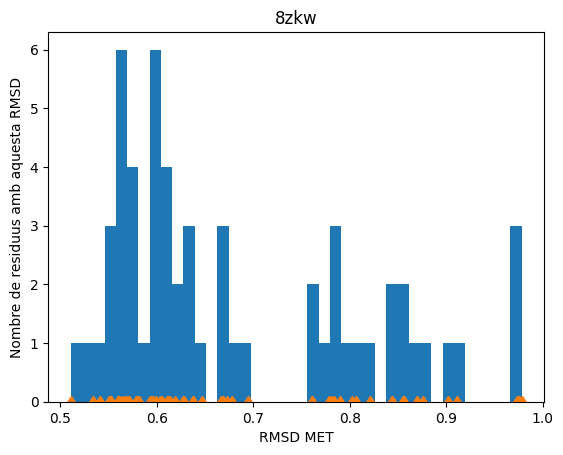

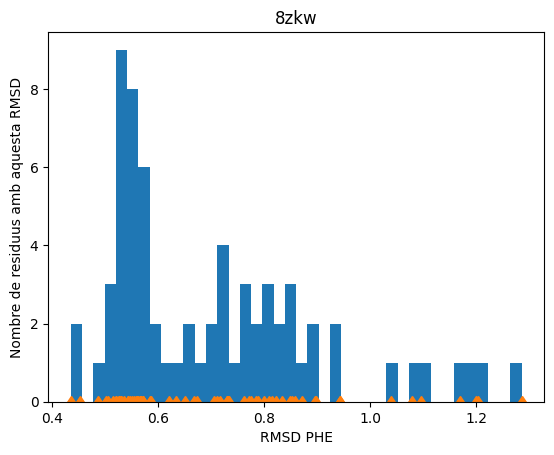

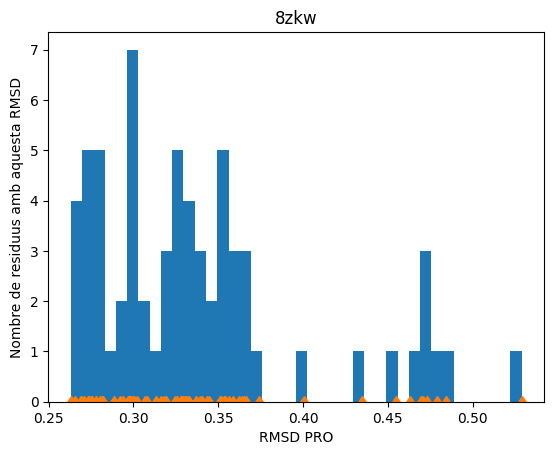

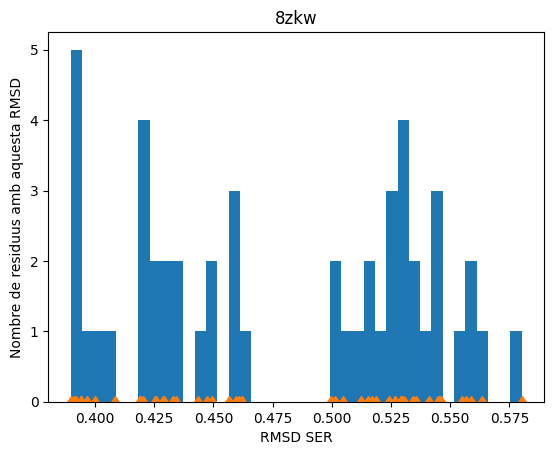

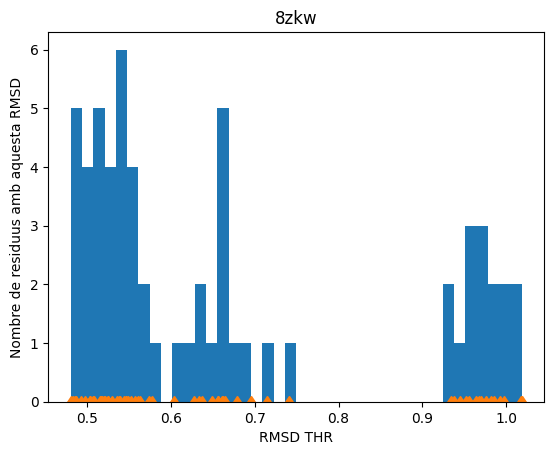

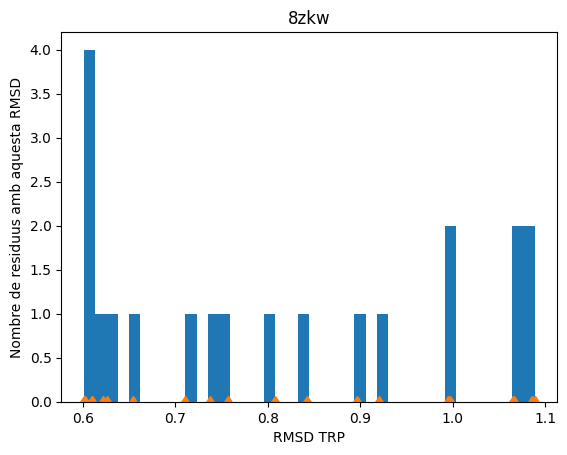

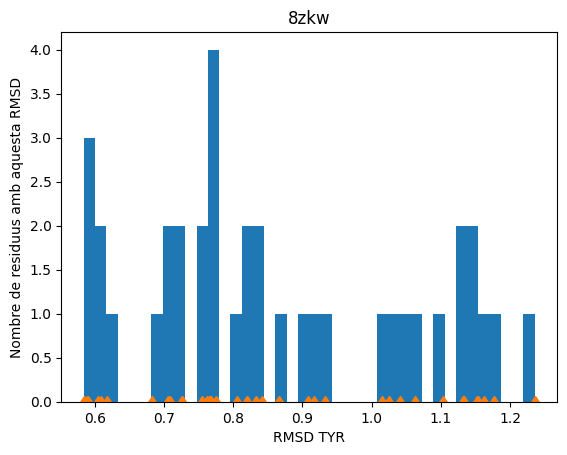

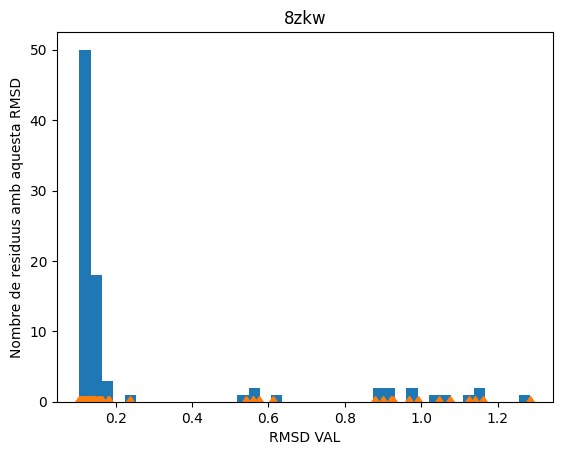

In [1]:
import MDAnalysis as mda
from MDAnalysis.analysis import align
import warnings
import numpy as np
import matplotlib.pyplot as plt
import os

warnings.filterwarnings('ignore') # suppress some MDAnalysis warnings about PSF files
print("Using MDAnalysis version", mda.__version__)


aminoacids = [
    "ALA", "ARG", "ASN", "ASP", "CYS", "GLN", "GLU", "GLY", "HIS", 
    "ILE", "LEU", "LYS", "MET", "PHE", "PRO", "SER", "THR", "TRP", "TYR", "VAL"
]
results_folder = "resultats"
data_folder = "dades"
molecule_file = input("quin fitxer de molecules vols analitzar? ")
molecule_name = molecule_file.split(".")[0]

def folder_check(folder_name):
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)

folder_check(results_folder)
folder_check(results_folder + "/" + molecule_name)

#funcions definides

def histogram(hist_data, hist_name, save, title):
    """
    prints and saves a histogram with the given distribution
    """
    hist_data = np.array(hist_data)
    
    fig, ax = plt.subplots()
    ax.hist(hist_data, bins=40 )
    # plot the xdata locations on the x axis:
    ax.plot(hist_data, 0*hist_data, 'd' )
    ax.set_ylabel('Nombre de residuus amb aquesta RMSD')
    ax.set_xlabel('RMSD '+ hist_name)
    plt.title(title)
    if save == True:
        plt.savefig(results_folder + "/" + molecule_name+ "/"+'histogram_'+hist_name+'.png', dpi=1000, bbox_inches='tight')


def average_structure(av_residu, av_univers, av_save, av_title):
    """
    For a given aminoacid and a universe, returns the average shape of that aminoacid in the universe
    """
    av_univers = av_univers.select_atoms("protein and resname "+av_residu)
    n_frames = len(av_univers.residues)
    if n_frames ==0:
        return
    n_atoms = len(av_univers.residues[0].atoms)
    with mda.Writer(results_folder + "/" + molecule_name+ "/" +av_residu +'.pdb', n_atoms) as w:
        for ts in range(n_frames):
            if len(av_univers.residues[ts].atoms)== n_atoms:
                w.write(av_univers.residues[ts].atoms)
            else: print(ts, "té algun problema a la " + av_residu)
    av_univers=mda.Universe(results_folder + "/" + molecule_name+ "/"+av_residu +'.pdb')
    average = align.AverageStructure(av_univers,
                                     ref_frame=0).run()

    ref = average.results.universe
    ref.atoms.write(results_folder + "/" + molecule_name+ "/"+"average_shape_" + av_residu+ " .pdb")
    
    mda.analysis.align.AlignTraj(av_univers, ref, select="protein", filename = results_folder + "/" + molecule_name+ "/" +"aligned_sequence_"+av_residu+".pdb").run()
    dist_dist = mda.analysis.rms.RMSD(av_univers, ref)
    dist_dist.run()
    
    histogram([av_result[2] for av_result in dist_dist.results.rmsd], av_residu, av_save,av_title)
    print("Hi ha " + str(len(dist_dist.results.rmsd))+ " " + av_residu) #Debuging
    os.remove(results_folder + "/" + molecule_name+ "/" +av_residu +'.pdb')

#Main
u = mda.Universe(data_folder+"/"+molecule_file)
#Es determinen les estructures mitjanes
save_histograms= True
for aminoacid in aminoacids:
    average_structure(aminoacid, u, save_histograms, molecule_name)



In [10]:
mda.Writer??

Signature: mda.Writer(filename, n_atoms=None, **kwargs)
Source:   
def writer(filename, n_atoms=None, **kwargs):
    """Initialize a trajectory writer instance for *filename*.

    Parameters
    ----------
    filename : str
        Output filename of the trajectory; the extension determines the
        format.
    n_atoms : int (optional)
        The number of atoms in the output trajectory; can be ommitted
        for single-frame writers.
    multiframe : bool (optional)
        ``True``: write a trajectory with multiple frames; ``False``
        only write a single frame snapshot; ``None`` first try to get
        a multiframe writer and then fall back to single frame [``None``]
    kwargs : optional
        Keyword arguments for the writer; all trajectory Writers accept
        ``start``: starting time [0], ``step``: step size in frames [1],
        ``dt``: length of time between two frames, in ps [1.0] Some readers
        accept additional arguments, which need to be looked up 

PDBIOException: Chain id ('aa') exceeds PDB format limit.

In [41]:
#Funcions definides que no han resultat útils al final
def distortion_distribution(dist_univers, dist_residu, dist_reference):
    """
    for a given aminoacid it calclates the RMSD 
    """
    dist_univers = dist_univers.select_atoms("resname "+dist_residu)
    distribution= []
    for res_i in dist_univers.residues:
        distribution.append(mda.analysis.rms.RMSD(dist_reference, res_i.atoms))
    histogram(distribution, dist_residu)
    print(len(distribution))
    

def max_list(m_list, m_select):
    """
    Given a list of tuples it returns the one that has the max value at a given position
    """
    m_max= m_list[0]
    for element in m_list:
        if element[m_select]>m_max[m_select]:
            m_max = element
    return m_max

def n_alpha_dist(protein):
    """
    For a given protein, it returns the distance between the c_alpha atom and its -COO atached carbon for each residue
    """
    if not isinstance(protein, mda.core.universe.Universe):
        raise TypeError(f"Expected input_value to be of type mda.core.universe.Universe, but got {type(protein).__name__}")
    distances = []
    for res in protein.residues:
        nitrogen = res.atoms.select_atoms("name N")
        carbon_a = res.atoms.select_atoms("name CA")
        if len(nitrogen) == 1 and len(carbon_a) == 1:
            distance = np.linalg.norm(nitrogen.positions[0] - carbon_a.positions[0])
            distances.append((res.resid, res.resname, distance))
        else:
            print(f"Skipping residue {res.resid} ({res.resname}) due to lacking infotmation")
    return distances
